In [1]:
import json
import os
import pickle
from collections import OrderedDict

import numpy as np
import requests


class SubmissionBase:
    submit_url = 'https://www.coursera.org/api/onDemandProgrammingScriptSubmissions.v1?includes=evaluation'
    save_file = 'token.pkl'

    def __init__(self, assignment_slug, assignment_key, part_names, part_names_key):
        self.assignment_slug = assignment_slug
        self.assignment_key = assignment_key
        self.part_names = part_names
        self.part_names_key = part_names_key
        self.login = None
        self.token = None
        self.functions = OrderedDict()
        self.args = dict()

    def grade(self):
        print('\nSubmitting Solutions | Programming Exercise %s\n' % self.assignment_slug)
        self.login_prompt()

        # Evaluate the different parts of exercise
        parts = OrderedDict()
        for part_id, result in self:
            parts[self.part_names_key[part_id - 1]] = {'output': sprintf('%0.5f ', result)}
        response = self.request(parts)
        response = json.loads(response.decode("utf-8"))

        # if an error was returned, print it and stop
        if 'errorCode' in response:
            print(response['message'], response['details']['learnerMessage'])
            return

        # Print the grading table
        print('%43s | %9s | %-s' % ('Part Name', 'Score', 'Feedback'))
        print('%43s | %9s | %-s' % ('---------', '-----', '--------'))
        for index, part in enumerate(parts):
            part_feedback = response['linked']['onDemandProgrammingScriptEvaluations.v1'][0]['parts'][str(part)][
                'feedback']
            part_evaluation = response['linked']['onDemandProgrammingScriptEvaluations.v1'][0]['parts'][str(part)]
            score = '%d / %3d' % (part_evaluation['score'], part_evaluation['maxScore'])
            print('%43s | %9s | %-s' % (self.part_names[int(index) - 1], score, part_feedback))
        evaluation = response['linked']['onDemandProgrammingScriptEvaluations.v1'][0]
        total_score = '%d / %d' % (evaluation['score'], evaluation['maxScore'])
        print('                                  --------------------------------')
        print('%43s | %9s | %-s\n' % (' ', total_score, ' '))

    def login_prompt(self):
        if os.path.isfile(self.save_file):
            with open(self.save_file, 'rb') as f:
                login, token = pickle.load(f)
            reenter = input('Use token from last successful submission (%s)? (Y/n): ' % login)

            if reenter == '' or reenter[0] == 'Y' or reenter[0] == 'y':
                self.login, self.token = login, token
                return
            else:
                os.remove(self.save_file)

        self.login = input('Login (email address): ')
        self.token = input('Token: ')

        # Save the entered credentials
        if not os.path.isfile(self.save_file):
            with open(self.save_file, 'wb') as f:
                pickle.dump((self.login, self.token), f)

    def request(self, parts):
        payload = {
            'assignmentKey': self.assignment_key,
            'submitterEmail': self.login,
            'secret': self.token,
            'parts': dict(eval(str(parts)))}
        headers = {}

        r = requests.post(self.submit_url, data=json.dumps(payload), headers=headers)
        return r.content

    def __iter__(self):
        for part_id in self.functions:
            yield part_id

    def __setitem__(self, key, value):
        self.functions[key] = value


def sprintf(fmt, arg):
    """ Emulates (part of) Octave sprintf function. """
    if isinstance(arg, tuple):
        # for multiple return values, only use the first one
        arg = arg[0]

    if isinstance(arg, (np.ndarray, list)):
        # concatenates all elements, column by column
        return ' '.join(fmt % e for e in np.asarray(arg).ravel('F'))
    else:
        return fmt % arg


In [2]:
import numpy as np
import sys
sys.path.append('..')

from submission import SubmissionBase


class Grader(SubmissionBase):
    X1 = np.column_stack((np.ones(20), np.exp(1) + np.exp(2) * np.linspace(0.1, 2, 20)))
    Y1 = X1[:, 1] + np.sin(X1[:, 0]) + np.cos(X1[:, 1])
    X2 = np.column_stack((X1, X1[:, 1]**0.5, X1[:, 1]**0.25))
    Y2 = np.power(Y1, 0.5) + Y1

    def __init__(self):
        part_names = ['Warm up exercise',
                      'Computing Cost (for one variable)',
                      'Gradient Descent (for one variable)',
                      'Feature Normalization',
                      'Computing Cost (for multiple variables)',
                      'Gradient Descent (for multiple variables)',
                      'Normal Equations']
        part_names_key = ['DCRbJ', 'BGa4S', 'b65eO', 'BbS8u', 'FBlE2', 'RZAZC', '7m5Eu']
        assignment_key = 'UkTlA-FyRRKV5ooohuwU6A'
        super().__init__('linear-regression', assignment_key, part_names, part_names_key)

    def __iter__(self):
        for part_id in range(1, 8):
            try:
                func = self.functions[part_id]

                # Each part has different expected arguments/different function
                if part_id == 1:
                    res = func()
                elif part_id == 2:
                    res = func(self.X1, self.Y1, np.array([0.5, -0.5]))
                elif part_id == 3:
                    res = func(self.X1, self.Y1, np.array([0.5, -0.5]), 0.01, 10)
                elif part_id == 4:
                    res = func(self.X2[:, 1:4])
                elif part_id == 5:
                    res = func(self.X2, self.Y2, np.array([0.1, 0.2, 0.3, 0.4]))
                elif part_id == 6:
                    res = func(self.X2, self.Y2, np.array([-0.1, -0.2, -0.3, -0.4]), 0.01, 10)
                elif part_id == 7:
                    res = func(self.X2, self.Y2)
                else:
                    raise KeyError
                yield part_id, res
            except KeyError:
                yield part_id, 0


# Programming Exercise 1: Linear Regression

## Introduction

In this exercise, you will implement linear regression and get to see it work on data. Before starting on this programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting.

You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [3]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting /library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# library written for this exercise providing additional functions for assignment submission, and others
#import utils 

# define the submission/grader object for this exercise
grader = Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Submission and Grading

After completing each part of the assignment, be sure to submit your solutions to the grader.

For this programming exercise, you are only required to complete the first part of the exercise to implement linear regression with one variable. The second part of the exercise, which is optional, covers linear regression with multiple variables. The following is a breakdown of how each part of this exercise is scored.

**Required Exercises**

| Section | Part                                           |Submitted Function                     | Points 
|---------|:-                                             |:-                                     | :-:    
| 1       | [Warm up exercise](#section1)                  | [`warmUpExercise`](#warmUpExercise)    |  10    
| 2       | [Compute cost for one variable](#section2)     | [`computeCost`](#computeCost)         |  40    
| 3       | [Gradient descent for one variable](#section3) | [`gradientDescent`](#gradientDescent) |  50    
|         | Total Points                                   |                                       | 100    

**Optional Exercises**

| Section | Part                                                 | Submitted Function | Points |
|:-------:|:-                                                    |:-:                  | :-:    |
| 4       | [Feature normalization](#section4)                   | [`featureNormalize`](#featureNormalize) | 0      |
| 5       | [Compute cost for multiple variables](#section5)     | [`computeCostMulti`](#computeCostMulti) | 0      |
| 6       | [Gradient descent for multiple variables](#section5) | [`gradientDescentMulti`](#gradientDescentMulti) |0      |
| 7       | [Normal Equations](#section7)                        | [`normalEqn`](#normalEqn)        | 0      |

You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

<div class="alert alert-block alert-warning">
At the end of each section in this notebook, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once. They must also be re-executed everytime the submitted function is updated.
</div>


## Debugging

Here are some things to keep in mind throughout this exercise:

- Python array indices start from zero, not one (contrary to OCTAVE/MATLAB). 

- There is an important distinction between python arrays (called `list` or `tuple`) and `numpy` arrays. You should use `numpy` arrays in all your computations. Vector/matrix operations work only with `numpy` arrays. Python lists do not support vector operations (you need to use for loops).

- If you are seeing many errors at runtime, inspect your matrix operations to make sure that you are adding and multiplying matrices of compatible dimensions. Printing the dimensions of `numpy` arrays using the `shape` property will help you debug.

- By default, `numpy` interprets math operators to be element-wise operators. If you want to do matrix multiplication, you need to use the `dot` function in `numpy`. For, example if `A` and `B` are two `numpy` matrices, then the matrix operation AB is `np.dot(A, B)`. Note that for 2-dimensional matrices or vectors (1-dimensional), this is also equivalent to `A@B` (requires python >= 3.5).

<a id="section1"></a>
## 1 Simple python and `numpy` function

The first part of this assignment gives you practice with python and `numpy` syntax and the homework submission process. In the next cell, you will find the outline of a `python` function. Modify it to return a 5 x 5 identity matrix by filling in the following code:

```python
A = np.eye(5)
```
<a id="warmUpExercise"></a>

In [4]:
def warmUpExercise():
    """
    Example function in Python which computes the identity matrix.
    
    Returns
    -------
    A : array_like
        The 5x5 identity matrix.
    
    Instructions
    ------------
    Return the 5x5 identity matrix.
    """    
    # ======== YOUR CODE HERE ======
    A = np.eye(5)   # modify this line
    
    # ==============================
    return A

The previous cell only defines the function `warmUpExercise`. We can now run it by executing the following cell to see its output. You should see output similar to the following:

```python
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])
```

In [5]:
warmUpExercise()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

### 1.1 Submitting solutions

After completing a part of the exercise, you can submit your solutions for grading by first adding the function you modified to the grader object, and then sending your function to Coursera for grading. 

The grader will prompt you for your login e-mail and submission token. You can obtain a submission token from the web page for the assignment. You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

Execute the next cell to grade your solution to the first part of this exercise.

*You should now submit your solutions.*

In [9]:
# appends the implemented function in part 1 to the grader object
grader[1] = warmUpExercise

# send the added functions to coursera grader for getting a grade on this part
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Login (email address): omarh.zahran@hotmail.com
Token: iXuYU9uCF9b5dUYn
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Normal Equations |  10 /  10 | Nice work!
                           Warm up exercise |   0 /  40 | Your answer is incorrect.
          Computing Cost (for one variable) |   0 /  50 | Your answer is incorrect.
        Gradient Descent (for one variable) |   0 /   0 | Your answer is incorrect.
                      Feature Normalization |   0 /   0 | Your answer is incorrect.
    Computing Cost (for multiple variables) |   0 /   0 | Your answer is incorrect.
  Gradient Descent (for multiple variables) |   0 /   0 | Your answer is incorrect.
                                  --------------------------------
                                            |  10 / 100 |  



## 2 Linear regression with one variable

Now you will implement linear regression with one variable to predict profits for a food truck. Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You would like to use this data to help you select which city to expand to next. 

The file `Data/ex1data1.txt` contains the dataset for our linear regression problem. The first column is the population of a city (in 10,000s) and the second column is the profit of a food truck in that city (in $10,000s). A negative value for profit indicates a loss. 

We provide you with the code needed to load this data. The dataset is loaded from the data file into the variables `x` and `y`:

In [11]:
# Read comma separated data
data = np.loadtxt('ex1data1.txt', delimiter=',')
X, y = data[:, 0], data[:, 1]

m = y.size  # number of training examples

### 2.1 Plotting the Data

Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). Many other problems that you will encounter in real life are multi-dimensional and cannot be plotted on a 2-d plot. There are many plotting libraries in python (see this [blog post](https://blog.modeanalytics.com/python-data-visualization-libraries/) for a good summary of the most popular ones). 

In this course, we will be exclusively using `matplotlib` to do all our plotting. `matplotlib` is one of the most popular scientific plotting libraries in python and has extensive tools and functions to make beautiful plots. `pyplot` is a module within `matplotlib` which provides a simplified interface to `matplotlib`'s most common plotting tasks, mimicking MATLAB's plotting interface.

<div class="alert alert-block alert-warning">
You might have noticed that we have imported the `pyplot` module at the beginning of this exercise using the command `from matplotlib import pyplot`. This is rather uncommon, and if you look at python code elsewhere or in the `matplotlib` tutorials, you will see that the module is named `plt`. This is used by module renaming by using the import command `import matplotlib.pyplot as plt`. We will not using the short name of `pyplot` module in this class exercises, but you should be aware of this deviation from norm.
</div>


In the following part, your first job is to complete the `plotData` function below. Modify the function and fill in the following code:

```python
    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel('Profit in $10,000')
    pyplot.xlabel('Population of City in 10,000s')
```

In [12]:
def plotData(x, y):
    """
    Plots the data points x and y into a new figure. Plots the data 
    points and gives the figure axes labels of population and profit.
    
    Parameters
    ----------
    x : array_like
        Data point values for x-axis.

    y : array_like
        Data point values for y-axis. Note x and y should have the same size.
    
    Instructions
    ------------
    Plot the training data into a figure using the "figure" and "plot"
    functions. Set the axes labels using the "xlabel" and "ylabel" functions.
    Assume the population and revenue data have been passed in as the x
    and y arguments of this function.    
    
    Hint
    ----
    You can use the 'ro' option with plot to have the markers
    appear as red circles. Furthermore, you can make the markers larger by
    using plot(..., 'ro', ms=10), where `ms` refers to marker size. You 
    can also set the marker edge color using the `mec` property.
    """
    fig = pyplot.figure()  # open a new figure
    
    # ====================== YOUR CODE HERE ======================= 
    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel('Profit in $10,000')
    pyplot.xlabel('Population of City in 10,000s')

    # =============================================================


Now run the defined function with the loaded data to visualize the data. The end result should look like the following figure:

![](Figures/dataset1.png)

Execute the next cell to visualize the data.

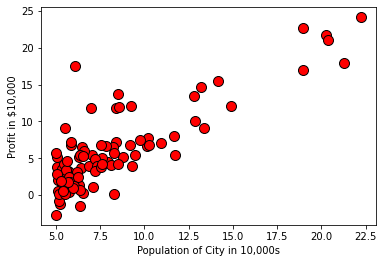

In [13]:
plotData(X, y)

To quickly learn more about the `matplotlib` plot function and what arguments you can provide to it, you can type `?pyplot.plot` in a cell within the jupyter notebook. This opens a separate page showing the documentation for the requested function. You can also search online for plotting documentation. 

To set the markers to red circles, we used the option `'or'` within the `plot` function.

In [14]:
?pyplot.plot

<a id="section2"></a>
### 2.2 Gradient Descent

In this part, you will fit the linear regression parameters $\theta$ to our dataset using gradient descent.

#### 2.2.1 Update Equations

The objective of linear regression is to minimize the cost function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_\theta(x)$ is given by the linear model
$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost J($\theta$).

<div class="alert alert-block alert-warning">
**Implementation Note:** We store each example as a row in the the $X$ matrix in Python `numpy`. To take into account the intercept term ($\theta_0$), we add an additional first column to $X$ and set it to all ones. This allows us to treat $\theta_0$ as simply another 'feature'.
</div>


#### 2.2.2 Implementation

We have already set up the data for linear regression. In the following cell, we add another dimension to our data to accommodate the $\theta_0$ intercept term. Do NOT execute this cell more than once.

In [16]:
# Add a column of ones to X. The numpy function stack joins arrays along a given axis. 
# The first axis (axis=0) refers to rows (training examples) 
# and second axis (axis=1) refers to columns (features).
X = np.stack([np.ones(m), X], axis=1)


ValueError: all input arrays must have the same shape

In [17]:
X

array([[ 1.    ,  6.1101],
       [ 1.    ,  5.5277],
       [ 1.    ,  8.5186],
       [ 1.    ,  7.0032],
       [ 1.    ,  5.8598],
       [ 1.    ,  8.3829],
       [ 1.    ,  7.4764],
       [ 1.    ,  8.5781],
       [ 1.    ,  6.4862],
       [ 1.    ,  5.0546],
       [ 1.    ,  5.7107],
       [ 1.    , 14.164 ],
       [ 1.    ,  5.734 ],
       [ 1.    ,  8.4084],
       [ 1.    ,  5.6407],
       [ 1.    ,  5.3794],
       [ 1.    ,  6.3654],
       [ 1.    ,  5.1301],
       [ 1.    ,  6.4296],
       [ 1.    ,  7.0708],
       [ 1.    ,  6.1891],
       [ 1.    , 20.27  ],
       [ 1.    ,  5.4901],
       [ 1.    ,  6.3261],
       [ 1.    ,  5.5649],
       [ 1.    , 18.945 ],
       [ 1.    , 12.828 ],
       [ 1.    , 10.957 ],
       [ 1.    , 13.176 ],
       [ 1.    , 22.203 ],
       [ 1.    ,  5.2524],
       [ 1.    ,  6.5894],
       [ 1.    ,  9.2482],
       [ 1.    ,  5.8918],
       [ 1.    ,  8.2111],
       [ 1.    ,  7.9334],
       [ 1.    ,  8.0959],
 

In [25]:
theta = np.zeros([X.shape[1]])
theta


array([0., 0.])

In [41]:
y_predict = X @ theta
z = y_predict - y
loss = (z @ z)/(2*y.size)
loss

32.07273387745567

<a id="section2"></a>
#### 2.2.3 Computing the cost $J(\theta)$

As you perform gradient descent to learn minimize the cost function $J(\theta)$, it is helpful to monitor the convergence by computing the cost. In this section, you will implement a function to calculate $J(\theta)$ so you can check the convergence of your gradient descent implementation. 

Your next task is to complete the code for the function `computeCost` which computes $J(\theta)$. As you are doing this, remember that the variables $X$ and $y$ are not scalar values. $X$ is a matrix whose rows represent the examples from the training set and $y$ is a vector whose each elemennt represent the value at a given row of $X$.
<a id="computeCost"></a>

In [33]:
def computeCost(X, y, theta):
    """
    Compute cost for linear regression. Computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of one's already 
        appended to the features so we have n+1 columns.
    
    y : array_like
        The values of the function at each data point. This is a vector of
        shape (m, ).
    
    theta : array_like
        The parameters for the regression function. This is a vector of 
        shape (n+1, ).
    
    Returns
    -------
    J : float
        The value of the regression cost function.
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. 
    You should set J to the cost.
    """
    
    # initialize some useful values
    m = y.size  # number of training examples
    
    # You need to return the following variables correctly
    J = 0
    
    # ====================== YOUR CODE HERE =====================
    y_predict = X @ theta
    z = y_predict - y
    J = (z @ z)/(2*m)
    
    # ===========================================================
    return J

Once you have completed the function, the next step will run `computeCost` two times using two different initializations of $\theta$. You will see the cost printed to the screen.

In [34]:
J = computeCost(X, y, theta=np.array([0.0, 0.0]))
print('With theta = [0, 0] \nCost computed = %.2f' % J)
print('Expected cost value (approximately) 32.07\n')

# further testing of the cost function
J = computeCost(X, y, theta=np.array([-1, 2]))
print('With theta = [-1, 2]\nCost computed = %.2f' % J)
print('Expected cost value (approximately) 54.24')

With theta = [0, 0] 
Cost computed = 32.07
Expected cost value (approximately) 32.07

With theta = [-1, 2]
Cost computed = 54.24
Expected cost value (approximately) 54.24


*You should now submit your solutions by executing the following cell.*

In [42]:
grader[2] = computeCost
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Use token from last successful submission (omarh.zahran@hotmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Normal Equations |  10 /  10 | Nice work!
                           Warm up exercise |  40 /  40 | Nice work!
          Computing Cost (for one variable) |   0 /  50 | Your answer is incorrect.
        Gradient Descent (for one variable) |   0 /   0 | Your answer is incorrect.
                      Feature Normalization |   0 /   0 | Your answer is incorrect.
    Computing Cost (for multiple variables) |   0 /   0 | Your answer is incorrect.
  Gradient Descent (for multiple variables) |   0 /   0 | Your answer is incorrect.
                                  --------------------------------
                                            |  50 / 100 |  



<a id="section3"></a>
#### 2.2.4 Gradient descent

Next, you will complete a function which implements gradient descent.
The loop structure has been written for you, and you only need to supply the updates to $\theta$ within each iteration. 

As you program, make sure you understand what you are trying to optimize and what is being updated. Keep in mind that the cost $J(\theta)$ is parameterized by the vector $\theta$, not $X$ and $y$. That is, we minimize the value of $J(\theta)$ by changing the values of the vector $\theta$, not by changing $X$ or $y$. [Refer to the equations in this notebook](#section2) and to the video lectures if you are uncertain. A good way to verify that gradient descent is working correctly is to look at the value of $J(\theta)$ and check that it is decreasing with each step. 

The starter code for the function `gradientDescent` calls `computeCost` on every iteration and saves the cost to a `python` list. Assuming you have implemented gradient descent and `computeCost` correctly, your value of $J(\theta)$ should never increase, and should converge to a steady value by the end of the algorithm.

<div class="alert alert-box alert-warning">
**Vectors and matrices in `numpy`** - Important implementation notes

A vector in `numpy` is a one dimensional array, for example `np.array([1, 2, 3])` is a vector. A matrix in `numpy` is a two dimensional array, for example `np.array([[1, 2, 3], [4, 5, 6]])`. However, the following is still considered a matrix `np.array([[1, 2, 3]])` since it has two dimensions, even if it has a shape of 1x3 (which looks like a vector).

Given the above, the function `np.dot` which we will use for all matrix/vector multiplication has the following properties:
- It always performs inner products on vectors. If `x=np.array([1, 2, 3])`, then `np.dot(x, x)` is a scalar.
- For matrix-vector multiplication, so if $X$ is a $m\times n$ matrix and $y$ is a vector of length $m$, then the operation `np.dot(y, X)` considers $y$ as a $1 \times m$ vector. On the other hand, if $y$ is a vector of length $n$, then the operation `np.dot(X, y)` considers $y$ as a $n \times 1$ vector.
- A vector can be promoted to a matrix using `y[None]` or `[y[np.newaxis]`. That is, if `y = np.array([1, 2, 3])` is a vector of size 3, then `y[None, :]` is a matrix of shape $1 \times 3$. We can use `y[:, None]` to obtain a shape of $3 \times 1$.
<div>
<a id="gradientDescent"></a>

In [43]:
def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).
    
    y : array_like
        Value at given features. A vector of shape (m, ).
    
    theta : array_like
        Initial values for the linear regression parameters. 
        A vector of shape (n+1, ).
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0]  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration
    
    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================
        y_predict = X @ theta
        
        gradient = (y_predict - y) @ X / m
        theta = theta - alpha*gradient
        # =====================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history

After you are finished call the implemented `gradientDescent` function and print the computed $\theta$. We initialize the $\theta$ parameters to 0 and the learning rate $\alpha$ to 0.01. Execute the following cell to check your code.

In [44]:
# initialize fitting parameters
theta = np.zeros(2)

# some gradient descent settings
iterations = 1500
alpha = 0.01

theta, J_history = gradientDescent(X ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))
print('Expected theta values (approximately): [-3.6303, 1.1664]')

Theta found by gradient descent: -3.6303, 1.1664
Expected theta values (approximately): [-3.6303, 1.1664]


We will use your final parameters to plot the linear fit. The results should look like the following figure.

![](Figures/regression_result.png)

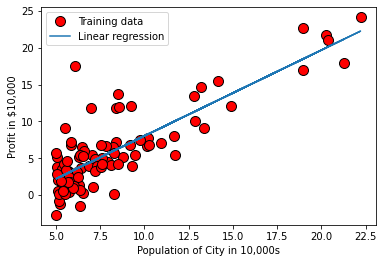

In [45]:
# plot the linear fit
plotData(X[:, 1], y)
pyplot.plot(X[:, 1], np.dot(X, theta), '-')
pyplot.legend(['Training data', 'Linear regression']);

Your final values for $\theta$ will also be used to make predictions on profits in areas of 35,000 and 70,000 people.

<div class="alert alert-block alert-success">
Note the way that the following lines use matrix multiplication, rather than explicit summation or looping, to calculate the predictions. This is an example of code vectorization in `numpy`.
</div>

<div class="alert alert-block alert-success">
Note that the first argument to the `numpy` function `dot` is a python list. `numpy` can internally converts **valid** python lists to numpy arrays when explicitly provided as arguments to `numpy` functions.
</div>


In [48]:
# Predict values for population sizes of 35,000 and 70,000
predict1 = np.dot([1, 3.5], theta)
print(predict1)
print('For population = 35,000, we predict a profit of {:.2f}\n'.format(predict1*10000))

predict2 = np.dot([1, 7], theta)
print('For population = 70,000, we predict a profit of {:.2f}\n'.format(predict2*10000))

0.4519767867701767
For population = 35,000, we predict a profit of 4519.77

For population = 70,000, we predict a profit of 45342.45



*You should now submit your solutions by executing the next cell.*

In [47]:
grader[3] = gradientDescent
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Use token from last successful submission (omarh.zahran@hotmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Normal Equations |  10 /  10 | Nice work!
                           Warm up exercise |  40 /  40 | Nice work!
          Computing Cost (for one variable) |  50 /  50 | Nice work!
        Gradient Descent (for one variable) |   0 /   0 | Your answer is incorrect.
                      Feature Normalization |   0 /   0 | Your answer is incorrect.
    Computing Cost (for multiple variables) |   0 /   0 | Your answer is incorrect.
  Gradient Descent (for multiple variables) |   0 /   0 | Your answer is incorrect.
                                  --------------------------------
                                            | 100 / 100 |  



### 2.4 Visualizing $J(\theta)$

To understand the cost function $J(\theta)$ better, you will now plot the cost over a 2-dimensional grid of $\theta_0$ and $\theta_1$ values. You will not need to code anything new for this part, but you should understand how the code you have written already is creating these images.

In the next cell, the code is set up to calculate $J(\theta)$ over a grid of values using the `computeCost` function that you wrote. After executing the following cell, you will have a 2-D array of $J(\theta)$ values. Then, those values are used to produce surface and contour plots of $J(\theta)$ using the matplotlib `plot_surface` and `contourf` functions. The plots should look something like the following:

![](Figures/cost_function.png)

The purpose of these graphs is to show you how $J(\theta)$ varies with changes in $\theta_0$ and $\theta_1$. The cost function $J(\theta)$ is bowl-shaped and has a global minimum. (This is easier to see in the contour plot than in the 3D surface plot). This minimum is the optimal point for $\theta_0$ and $\theta_1$, and each step of gradient descent moves closer to this point.

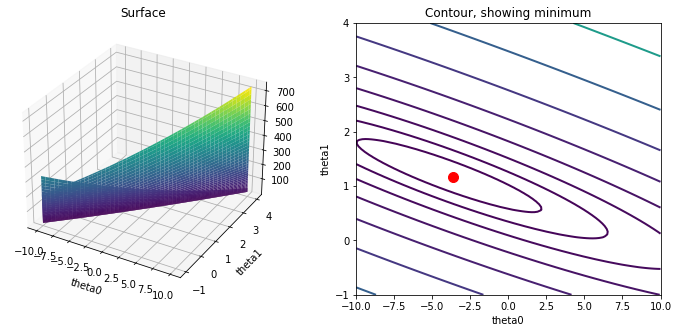

In [49]:
# grid over which we will calculate J
theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-1, 4, 100)

# initialize J_vals to a matrix of 0's
J_vals = np.zeros((theta0_vals.shape[0], theta1_vals.shape[0]))

# Fill out J_vals
for i, theta0 in enumerate(theta0_vals):
    for j, theta1 in enumerate(theta1_vals):
        J_vals[i, j] = computeCost(X, y, [theta0, theta1])
        
# Because of the way meshgrids work in the surf command, we need to
# transpose J_vals before calling surf, or else the axes will be flipped
J_vals = J_vals.T

# surface plot
fig = pyplot.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(theta0_vals, theta1_vals, J_vals, cmap='viridis')
pyplot.xlabel('theta0')
pyplot.ylabel('theta1')
pyplot.title('Surface')

# contour plot
# Plot J_vals as 15 contours spaced logarithmically between 0.01 and 100
ax = pyplot.subplot(122)
pyplot.contour(theta0_vals, theta1_vals, J_vals, linewidths=2, cmap='viridis', levels=np.logspace(-2, 3, 20))
pyplot.xlabel('theta0')
pyplot.ylabel('theta1')
pyplot.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
pyplot.title('Contour, showing minimum')
pass

## Optional Exercises

If you have successfully completed the material above, congratulations! You now understand linear regression and should able to start using it on your own datasets.

For the rest of this programming exercise, we have included the following optional exercises. These exercises will help you gain a deeper understanding of the material, and if you are able to do so, we encourage you to complete them as well. You can still submit your solutions to these exercises to check if your answers are correct.

## 3 Linear regression with multiple variables

In this part, you will implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file `Data/ex1data2.txt` contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price
of the house. 

<a id="section4"></a>
### 3.1 Feature Normalization

We start by loading and displaying some values from this dataset. By looking at the values, note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly.

In [50]:
# Load data
data = np.loadtxt('ex1data2.txt', delimiter=',')
X = data[:, :2]
y = data[:, 2]
m = y.size

# print out some data points
print('{:>8s}{:>8s}{:>10s}'.format('X[:,0]', 'X[:, 1]', 'y'))
print('-'*26)
for i in range(10):
    print('{:8.0f}{:8.0f}{:10.0f}'.format(X[i, 0], X[i, 1], y[i]))

  X[:,0] X[:, 1]         y
--------------------------
    2104       3    399900
    1600       3    329900
    2400       3    369000
    1416       2    232000
    3000       4    539900
    1985       4    299900
    1534       3    314900
    1427       3    198999
    1380       3    212000
    1494       3    242500


Your task here is to complete the code in `featureNormalize` function:
- Subtract the mean value of each feature from the dataset.
- After subtracting the mean, additionally scale (divide) the feature values by their respective “standard deviations.”

The standard deviation is a way of measuring how much variation there is in the range of values of a particular feature (most data points will lie within ±2 standard deviations of the mean); this is an alternative to taking the range of values (max-min). In `numpy`, you can use the `std` function to compute the standard deviation. 

For example, the quantity `X[:, 0]` contains all the values of $x_1$ (house sizes) in the training set, so `np.std(X[:, 0])` computes the standard deviation of the house sizes.
At the time that the function `featureNormalize` is called, the extra column of 1’s corresponding to $x_0 = 1$ has not yet been added to $X$. 

You will do this for all the features and your code should work with datasets of all sizes (any number of features / examples). Note that each column of the matrix $X$ corresponds to one feature.

<div class="alert alert-block alert-warning">
**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bedrooms), we must first normalize x using the mean and standard deviation that we had previously computed from the training set.
</div>
<a id="featureNormalize"></a>

In [69]:
X.mean(axis=0)

array([2000.68085106,    3.17021277])

In [70]:
def  featureNormalize(X):
    """
    Normalizes the features in X. returns a normalized version of X where
    the mean value of each feature is 0 and the standard deviation
    is 1. This is often a good preprocessing step to do when working with
    learning algorithms.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n).
    
    Returns
    -------
    X_norm : array_like
        The normalized dataset of shape (m x n).
    
    Instructions
    ------------
    First, for each feature dimension, compute the mean of the feature
    and subtract it from the dataset, storing the mean value in mu. 
    Next, compute the  standard deviation of each feature and divide
    each feature by it's standard deviation, storing the standard deviation 
    in sigma. 
    
    Note that X is a matrix where each column is a feature and each row is
    an example. You needto perform the normalization separately for each feature. 
    
    Hint
    ----
    You might find the 'np.mean' and 'np.std' functions useful.
    """
    # You need to set these values correctly
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    # =========================== YOUR CODE HERE =====================
    mu = np.mean(X,axis=0)
    sigma = np.std(X,axis=0)
    X_norm = (X - mu)/sigma
    # ================================================================
    return X_norm, mu, sigma

Execute the next cell to run the implemented `featureNormalize` function.

In [71]:
X_norm

array([[ 9.64150080e-01, -8.73910212e-01],
       [ 5.23225574e-01, -8.73910212e-01],
       [ 1.22310574e+00, -8.73910212e-01],
       [ 3.62253135e-01, -8.74785062e-01],
       [ 1.74801587e+00, -8.73035361e-01],
       [ 8.60042905e-01, -8.73035361e-01],
       [ 4.65485460e-01, -8.73910212e-01],
       [ 3.71876488e-01, -8.73910212e-01],
       [ 3.30758528e-01, -8.73910212e-01],
       [ 4.30491452e-01, -8.73910212e-01],
       [ 8.20674646e-01, -8.73035361e-01],
       [ 8.73165658e-01, -8.73910212e-01],
       [ 7.76932135e-01, -8.73910212e-01],
       [ 3.04104448e+00, -8.72160511e-01],
       [ 2.32775304e-01, -8.73910212e-01],
       [ 1.13562072e+00, -8.73035361e-01],
       [ 2.78267515e-01, -8.74785062e-01],
       [ 2.04780098e-01, -8.73910212e-01],
       [ 1.40594944e+00, -8.73035361e-01],
       [ 1.77513622e+00, -8.73035361e-01],
       [ 6.69325559e-01, -8.73910212e-01],
       [ 7.75182435e-01, -8.74785062e-01],
       [ 5.26724975e-01, -8.73910212e-01],
       [ 8.

In [72]:
# call featureNormalize on the loaded data
X_norm, mu, sigma = featureNormalize(X)

print('Computed mean:', mu)
print('Computed standard deviation:', sigma)

Computed mean: [2000.68085106    3.17021277]
Computed standard deviation: [7.86202619e+02 7.52842809e-01]


*You should now submit your solutions.*

In [91]:
grader[4] = featureNormalize
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Use token from last successful submission (omarh.zahran@hotmail.com)? (Y/n): n
Login (email address): omarh.zahran@hotmail.com
Token: XxPHPE2aPnx1aKBH
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Normal Equations |  10 /  10 | Nice work!
                           Warm up exercise |  40 /  40 | Nice work!
          Computing Cost (for one variable) |  50 /  50 | Nice work!
        Gradient Descent (for one variable) |   0 /   0 | Nice work!
                      Feature Normalization |   0 /   0 | Nice work!
    Computing Cost (for multiple variables) |   0 /   0 | Your answer is incorrect.
  Gradient Descent (for multiple variables) |   0 /   0 | Your answer is incorrect.
                                  --------------------------------
                                            | 100 / 100 |  



After the `featureNormalize` function is tested, we now add the intercept term to `X_norm`:

In [92]:
# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

In [93]:
X

array([[ 1.00000000e+00,  1.31415422e-01, -2.26093368e-01],
       [ 1.00000000e+00, -5.09640698e-01, -2.26093368e-01],
       [ 1.00000000e+00,  5.07908699e-01, -2.26093368e-01],
       [ 1.00000000e+00, -7.43677059e-01, -1.55439190e+00],
       [ 1.00000000e+00,  1.27107075e+00,  1.10220517e+00],
       [ 1.00000000e+00, -1.99450507e-02,  1.10220517e+00],
       [ 1.00000000e+00, -5.93588523e-01, -2.26093368e-01],
       [ 1.00000000e+00, -7.29685755e-01, -2.26093368e-01],
       [ 1.00000000e+00, -7.89466782e-01, -2.26093368e-01],
       [ 1.00000000e+00, -6.44465993e-01, -2.26093368e-01],
       [ 1.00000000e+00, -7.71822042e-02,  1.10220517e+00],
       [ 1.00000000e+00, -8.65999486e-04, -2.26093368e-01],
       [ 1.00000000e+00, -1.40779041e-01, -2.26093368e-01],
       [ 1.00000000e+00,  3.15099326e+00,  2.43050370e+00],
       [ 1.00000000e+00, -9.31923697e-01, -2.26093368e-01],
       [ 1.00000000e+00,  3.80715024e-01,  1.10220517e+00],
       [ 1.00000000e+00, -8.65782986e-01

<a id="section5"></a>
### 3.2 Gradient Descent

Previously, you implemented gradient descent on a univariate regression problem. The only difference now is that there is one more feature in the matrix $X$. The hypothesis function and the batch gradient descent update
rule remain unchanged. 

You should complete the code for the functions `computeCostMulti` and `gradientDescentMulti` to implement the cost function and gradient descent for linear regression with multiple variables. If your code in the previous part (single variable) already supports multiple variables, you can use it here too.
Make sure your code supports any number of features and is well-vectorized.
You can use the `shape` property of `numpy` arrays to find out how many features are present in the dataset.

<div class="alert alert-block alert-warning">
**Implementation Note:** In the multivariate case, the cost function can
also be written in the following vectorized form:

$$ J(\theta) = \frac{1}{2m}(X\theta - \vec{y})^T(X\theta - \vec{y}) $$

where 

$$ X = \begin{pmatrix}
          - (x^{(1)})^T - \\
          - (x^{(2)})^T - \\
          \vdots \\
          - (x^{(m)})^T - \\ \\
        \end{pmatrix} \qquad \mathbf{y} = \begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)} \\\end{bmatrix}$$

the vectorized version is efficient when you are working with numerical computing tools like `numpy`. If you are an expert with matrix operations, you can prove to yourself that the two forms are equivalent.
</div>

<a id="computeCostMulti"></a>

In [105]:
def computeCostMulti(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # You need to return the following variable correctly
    J = 0
    #theta = np.zeros(X.shape[1])
    # ======================= YOUR CODE HERE ===========================
    y_predict = X @ theta
    z = y_predict - y
    J = (z @ z)/(2*m)
    
    # ==================================================================
    return J


In [106]:
test = computeCostMulti(X, y, theta=np.array([0,0,0]))
test

65591548106.45744

*You should now submit your solutions.*

In [107]:
grader[5] = computeCostMulti
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Use token from last successful submission (omarh.zahran@hotmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Normal Equations |  10 /  10 | Nice work!
                           Warm up exercise |  40 /  40 | Nice work!
          Computing Cost (for one variable) |  50 /  50 | Nice work!
        Gradient Descent (for one variable) |   0 /   0 | Nice work!
                      Feature Normalization |   0 /   0 | Nice work!
    Computing Cost (for multiple variables) |   0 /   0 | Your answer is incorrect.
  Gradient Descent (for multiple variables) |   0 /   0 | Your answer is incorrect.
                                  --------------------------------
                                            | 100 / 100 |  



<a id="gradientDescentMulti"></a>

In [113]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
        # ======================= YOUR CODE HERE ==========================
        y_predict = X @ theta
        
        gradient = (y_predict - y) @ X / m
        theta = theta - alpha*gradient
        
        # =================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history

*You should now submit your solutions.*

In [114]:
grader[6] = gradientDescentMulti
grader.grade()


Submitting Solutions | Programming Exercise linear-regression

Use token from last successful submission (omarh.zahran@hotmail.com)? (Y/n): Y


TypeError: gradientDescentMulti() missing 3 required positional arguments: 'theta', 'alpha', and 'num_iters'

#### 3.2.1 Optional (ungraded) exercise: Selecting learning rates

In this part of the exercise, you will get to try out different learning rates for the dataset and find a learning rate that converges quickly. You can change the learning rate by modifying the following code and changing the part of the code that sets the learning rate.

Use your implementation of `gradientDescentMulti` function and run gradient descent for about 50 iterations at the chosen learning rate. The function should also return the history of $J(\theta)$ values in a vector $J$.

After the last iteration, plot the J values against the number of the iterations.

If you picked a learning rate within a good range, your plot look similar as the following Figure. 

![](Figures/learning_rate.png)

If your graph looks very different, especially if your value of $J(\theta)$ increases or even blows up, adjust your learning rate and try again. We recommend trying values of the learning rate $\alpha$ on a log-scale, at multiplicative steps of about 3 times the previous value (i.e., 0.3, 0.1, 0.03, 0.01 and so on). You may also want to adjust the number of iterations you are running if that will help you see the overall trend in the curve.

<div class="alert alert-block alert-warning">
**Implementation Note:** If your learning rate is too large, $J(\theta)$ can diverge and ‘blow up’, resulting in values which are too large for computer calculations. In these situations, `numpy` will tend to return
NaNs. NaN stands for ‘not a number’ and is often caused by undefined operations that involve −∞ and +∞.
</div>

<div class="alert alert-block alert-warning">
**MATPLOTLIB tip:** To compare how different learning learning rates affect convergence, it is helpful to plot $J$ for several learning rates on the same figure. This can be done by making `alpha` a python list, and looping across the values within this list, and calling the plot function in every iteration of the loop. It is also useful to have a legend to distinguish the different lines within the plot. Search online for `pyplot.legend` for help on showing legends in `matplotlib`.
</div>

Notice the changes in the convergence curves as the learning rate changes. With a small learning rate, you should find that gradient descent takes a very long time to converge to the optimal value. Conversely, with a large learning rate, gradient descent might not converge or might even diverge!
Using the best learning rate that you found, run the script
to run gradient descent until convergence to find the final values of $\theta$. Next,
use this value of $\theta$ to predict the price of a house with 1650 square feet and
3 bedrooms. You will use value later to check your implementation of the normal equations. Don’t forget to normalize your features when you make this prediction!

In [ ]:
"""
Instructions
------------
We have provided you with the following starter code that runs
gradient descent with a particular learning rate (alpha). 

Your task is to first make sure that your functions - `computeCost`
and `gradientDescent` already work with  this starter code and
support multiple variables.

After that, try running gradient descent with different values of
alpha and see which one gives you the best result.

Finally, you should complete the code at the end to predict the price
of a 1650 sq-ft, 3 br house.

Hint
----
At prediction, make sure you do the same feature normalization.
"""
# Choose some alpha value - change this
alpha = 0.1
num_iters = 400

# init theta and run gradient descent
theta = np.zeros(3)
theta, J_history = gradientDescentMulti(X, y, theta, alpha, num_iters)

# Plot the convergence graph
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

# Display the gradient descent's result
print('theta computed from gradient descent: {:s}'.format(str(theta)))

# Estimate the price of a 1650 sq-ft, 3 br house
# ======================= YOUR CODE HERE ===========================
# Recall that the first column of X is all-ones. 
# Thus, it does not need to be normalized.

price = 0   # You should change this

# ===================================================================

print('Predicted price of a 1650 sq-ft, 3 br house (using gradient descent): ${:.0f}'.format(price))

*You do not need to submit any solutions for this optional (ungraded) part.*

<a id="section7"></a>
### 3.3 Normal Equations

In the lecture videos, you learned that the closed-form solution to linear regression is

$$ \theta = \left( X^T X\right)^{-1} X^T\vec{y}$$

Using this formula does not require any feature scaling, and you will get an exact solution in one calculation: there is no “loop until convergence” like in gradient descent. 

First, we will reload the data to ensure that the variables have not been modified. Remember that while you do not need to scale your features, we still need to add a column of 1’s to the $X$ matrix to have an intercept term ($\theta_0$). The code in the next cell will add the column of 1’s to X for you.

In [ ]:
# Load data
data = np.loadtxt(os.path.join('Data', 'ex1data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]
m = y.size
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Complete the code for the function `normalEqn` below to use the formula above to calculate $\theta$. 

<a id="normalEqn"></a>

In [ ]:
def normalEqn(X, y):
    """
    Computes the closed-form solution to linear regression using the normal equations.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        The value at each data point. A vector of shape (m, ).
    
    Returns
    -------
    theta : array_like
        Estimated linear regression parameters. A vector of shape (n+1, ).
    
    Instructions
    ------------
    Complete the code to compute the closed form solution to linear
    regression and put the result in theta.
    
    Hint
    ----
    Look up the function `np.linalg.pinv` for computing matrix inverse.
    """
    theta = np.zeros(X.shape[1])
    
    # ===================== YOUR CODE HERE ============================

    
    # =================================================================
    return theta

*You should now submit your solutions.*

In [ ]:
grader[7] = normalEqn
grader.grade()

Optional (ungraded) exercise: Now, once you have found $\theta$ using this
method, use it to make a price prediction for a 1650-square-foot house with
3 bedrooms. You should find that gives the same predicted price as the value
you obtained using the model fit with gradient descent (in Section 3.2.1).

In [ ]:
# Calculate the parameters from the normal equation
theta = normalEqn(X, y);

# Display normal equation's result
print('Theta computed from the normal equations: {:s}'.format(str(theta)));

# Estimate the price of a 1650 sq-ft, 3 br house
# ====================== YOUR CODE HERE ======================

price = 0 # You should change this

# ============================================================

print('Predicted price of a 1650 sq-ft, 3 br house (using normal equations): ${:.0f}'.format(price))